# Clusterización de información de productos en función de características

## Importación de librerias necesarias

In [1]:
%load_ext IPython.extensions.autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path

def find_src_folder(current_path: Path, folder_name: str = 'src') -> Path:
    search_directories = [current_path] + list(current_path.parents)
    for parent in search_directories:
        if parent.name == folder_name:
            return parent.parent
    return current_path

src_path = find_src_folder(Path.cwd(), 'src')
sys.path.append(str(src_path))

In [3]:
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np

import pandas as pd

from matplotlib.ticker import FuncFormatter

import tensorflow_hub as hub

from sklearn.neighbors import NearestNeighbors

from langchain_ollama.embeddings import OllamaEmbeddings

from sklearn.cluster import DBSCAN

from src.utils import SparkUtils

2025-06-15 21:34:52.656815: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-15 21:34:52.799613: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-15 21:34:52.943392: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750041293.048640   87350 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750041293.080744   87350 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-15 21:34:53.359601: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [4]:
spark_utils = SparkUtils()

your 131072x1 screen size is bogus. expect trouble
25/06/15 21:35:58 WARN Utils: Your hostname, ASUSPRIMEA520MAII resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/06/15 21:35:58 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/mnt/c/Users/User/Documents/Maestr%c3%ada/Amazon%20Reviews%20Code/.venv/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/edgar/.ivy2/cache
The jars for the packages stored in: /home/edgar/.ivy2/jars
io.delta#delta-spark_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-49bd0a97-3664-4fa9-8f81-349b4dbded78;1.0
	confs: [default]
	found io.delta#delta-spark_2.12;3.3.1 in central
	found io.delta#delta-storage;3.3.1 in central
	found org.antlr#antlr4-runtime;4.9.3 in central
:: resolution report :: resolve 217ms :: artifacts dl 6ms
	:: modules in use:
	io.delta#delta-spark_2.12;3.3.1 from central in [default]
	io.delta#delta-storage;3.3.1 from central in [default]
	org.antlr#antlr4-runtime;4.9.3 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   3   |   0   

## Cargar modelo embedding (Llama3)

In [5]:
# https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder?hl=es-419
MODULE_URL = "https://tfhub.dev/google/universal-sentence-encoder-large/5"
model = hub.load( MODULE_URL )

2025-06-15 21:36:12.958166: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## Generar agrupación basada en título de primera cuantificación de item 

#### Cargar información de títulos

In [6]:
meta_items_pandas_sample = spark_utils.get_meta_items_sample( 1000 )

In [7]:
sentences = meta_items_pandas_sample['title'].to_list()

In [8]:
embeddings_np = model( sentences )

In [9]:
embeddings_np.shape

TensorShape([1000, 512])

#### Agglomerative Clustering

In [10]:
N_AGGLOMERATIVE_CLUSTERS = 5

In [11]:
agg_model = AgglomerativeClustering(n_clusters=N_AGGLOMERATIVE_CLUSTERS, linkage='ward')
labels = agg_model.fit_predict(embeddings_np)

meta_items_pandas_sample['agg_cluster'] = labels

**Examinar agrupaciones resultado**

Examinar ejemplos de cada una de las agrupaciones generadas

In [12]:
for i in range( N_AGGLOMERATIVE_CLUSTERS ):
    print(f">>>> Cluster {i + 1}")
    display( meta_items_pandas_sample[ meta_items_pandas_sample['agg_cluster'] == i ][['title', 'agg_cluster']].head(10) )
    print(f">>>>\n")

>>>> Cluster 1


,title,agg_cluster
0,Accupressure Guide,0
1,Ankylosaurus Fights Back - Smithsonian's Prehi...,0
3,Jewels Brick Breakout,0
5,Shadow Fighting Superhero War,0
7,Giant Surprise Petcage! Unlock Superhero Puppy,0
8,Ac Market tips,0
9,Gem Shopping Network,0
10,Piano Wizard Premier With 49E Keystation,0
14,For Rent: Haunted House,0
15,Fat Dragons,0


>>>>

>>>> Cluster 2


,title,agg_cluster
19,Corel PaintShop Pro X4 [Old Version],1
20,Que Publishing 0789738252 Power Excel 2007 wit...,1
42,TurboTax Deluxe 2014 Fed + State + Fed Efile T...,1
45,Microsoft Virtual PC for Mac 6.1 [Old Version],1
47,AutoCAD Freestyle [Old Version],1
48,Anime Studio Pro 9.5,1
54,Kaspersky Internet Security Multi-Device 2015 ...,1
60,MyScript Studio Notes Edition [Download],1
82,Stooge Deluge (4 pack) Vol. 1,1
87,TurboTax Deluxe Fed 2022,1


>>>>

>>>> Cluster 3


,title,agg_cluster
4,Traffic Police: Off-Road Cub,2
6,My Aquarium - Hidden Object Challenge # 122,2
11,Boxing Game 3D - Real Fighting,2
12,RoverCraft Race Your Space Car,2
24,Soccer by Fawesome.tv,2
25,Last Survivor - Zombie Attack - Free Survival ...,2
26,PlayHOG # 216 Hidden Object Games Free New - T...,2
28,How to Start a Boarding School Plus Business Plan,2
40,Old Truck Transporter,2
41,Spin Fight,2


>>>>

>>>> Cluster 4


,title,agg_cluster
43,Dinosaurus,3
84,96.1BOBFM,3
91,NextView,3
100,LoanPayment,3
101,Ending,3
107,NewsWatch,3
109,aCheckbook+,3
118,Sheepshead,3
161,WikiPedi,3
165,UniWar,3


>>>>

>>>> Cluster 5


,title,agg_cluster
2,Mahjong 2015,4
13,HALLOWEEN MATCH 3 IN A ROW,4
67,2048 Drop n Merge Numbers: Match 3 Columns Puzzle,4
120,Mahjong Holiday Joy 2016,4
122,Wood Block Puzzle - Sudoku Woody Block Puzzles...,4
125,Royal Hearts Slot,4
134,Beard Salon – Free Games for Kids.,4
152,Crossword - Portuguese,4
191,Slots,4
214,Pyramid Solitaire,4


>>>>



#### DBScan Clustering

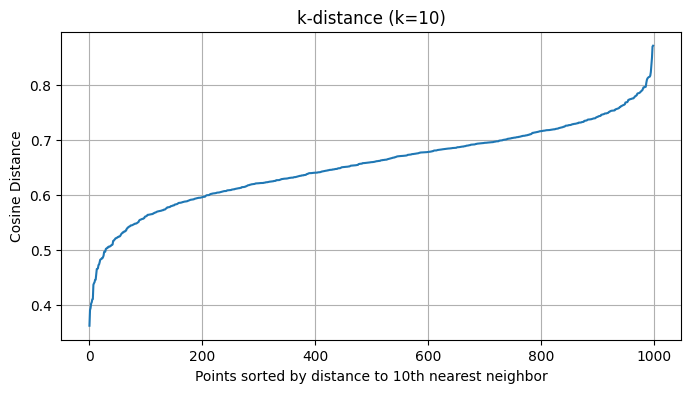

In [13]:
X = embeddings_np

neighbors = NearestNeighbors(n_neighbors=10, metric='cosine')
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

k_distances = np.sort(distances[:, 9])

plt.figure(figsize=(8, 4))
plt.plot(k_distances)
plt.title("k-distance (k=10)")
plt.xlabel("Points sorted by distance to 10th nearest neighbor")
plt.ylabel("Cosine Distance")
plt.grid(True)
plt.show()

In [14]:
dbscan_model = DBSCAN(
    eps = 0.5,
    metric = 'cosine',
    min_samples = 10
)

In [15]:
meta_items_pandas_sample['dbscan_cluster'] = dbscan_model.fit_predict( embeddings_np )

In [16]:
dbscan_labels = set(dbscan_model.labels_)

In [17]:
dbscan_labels

{np.int64(-1), np.int64(0), np.int64(1), np.int64(2), np.int64(3)}

In [18]:
for i in dbscan_labels:
    print(f">>>> Cluster {i + 1}")
    display( meta_items_pandas_sample[ meta_items_pandas_sample['dbscan_cluster'] == i ][['title', 'dbscan_cluster']].head(10) )
    print(f">>>>\n")

>>>> Cluster 1


,title,dbscan_cluster
19,Corel PaintShop Pro X4 [Old Version],0
42,TurboTax Deluxe 2014 Fed + State + Fed Efile T...,0
47,AutoCAD Freestyle [Old Version],0
48,Anime Studio Pro 9.5,0
87,TurboTax Deluxe Fed 2022,0
99,CrazyTalk7 Standard - Mac [Download],0
144,MAGIX Movie Edit Pro 2017 Plus,0
148,H&R Block 2015 Basic Tax Software + Refund Bon...,0
175,Xara Web Designer 7 (Old Version) [Download],0
177,TurboTax Basic 2007 [OLD VERSION],0


>>>>

>>>> Cluster 2


,title,dbscan_cluster
103,Bubble Burst (Kindle Tablet Edition),1
156,Hawaii Drive Guides (Kindle Tablet Edition),1
225,Guitar (Kindle Tablet Edition),1
332,RFCU Mobile Banking (Kindle Tablet Edition),1
341,First Alphabet HD Lite (Kindle Tablet Edition),1
365,Mazes - logic games,1
427,Puzzle & Dragons (Kindle Tablet Edition),1
461,Mayan Treasure - Vegas 5 Reel Slot Machine (Ki...,1
466,The Daily News e-Edition (Kindle Tablet Edition),1
491,Solar System Jigsaw Puzzle,1


>>>>

>>>> Cluster 3


,title,dbscan_cluster
2,Mahjong 2015,2
120,Mahjong Holiday Joy 2016,2
214,Pyramid Solitaire,2
302,"Thanksgiving Solitaire - Freecell, Classic Sol...",2
345,Mahjong Dragon - Mahjong Solitaire,2
354,Trickster Spades,2
538,Mahjong 2,2
601,FreeCell Solitaire Champion,2
659,Classic Solitaire 2021,2
763,Sudoku Epic,2


>>>>

>>>> Cluster 4


,title,dbscan_cluster
140,Car Stunt Races: Mega Ramps,3
204,Monster Truck Drive 2020 Legends Adventure,3
265,Stunt Extreme 3D: Moto Traffic Bike Racer,3
301,Retro Future Racing,3
410,Street Car Race 2021 : Crazy Freeway Car Racin...,3
421,Traffic Rider 3D : The Street Racing Moto 2022,3
459,The Bestest Motorcycle Racer - Small Town Racing,3
470,Drag Drift Racer Online,3
508,Sport Cars Addon for MCPE,3
543,Drift: Car Drifting Race Free Game,3


>>>>

>>>> Cluster 0


,title,dbscan_cluster
0,Accupressure Guide,-1
1,Ankylosaurus Fights Back - Smithsonian's Prehi...,-1
3,Jewels Brick Breakout,-1
4,Traffic Police: Off-Road Cub,-1
5,Shadow Fighting Superhero War,-1
6,My Aquarium - Hidden Object Challenge # 122,-1
7,Giant Surprise Petcage! Unlock Superhero Puppy,-1
8,Ac Market tips,-1
9,Gem Shopping Network,-1
10,Piano Wizard Premier With 49E Keystation,-1


>>>>

